# **Klasifikasi Gambar Penyakit Kulit Kucing**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan penyakit kulit kucing menggunakan gambar.

## **Sumber Dataset**
https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease-v2

# **Import Libraries**

In [280]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [281]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [282]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"azimafauzan","key":"0cf2b3490c3fc18c87838e3f14252b43"}'}

In [283]:
!rm -rf cat-skin-disease-v2/

In [284]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityavahreza/cat-skin-disease-v2
!unzip -o cat-skin-disease-v2.zip

Dataset URL: https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease-v2
License(s): unknown
cat-skin-disease-v2.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cat-skin-disease-v2.zip
  inflating: CAT SKIN DISEASE/Flea_Allergy/1000010593_x4.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/1000010601_x4.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/1000010627_x4.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/1000010771_x16.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/340947808_546167834308890_7592465449990658927_n.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/5d5641b96b930df01eb7df119e680c9fdb41f4e4_jpeg.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/Atopic-dermatitis_Red-skin-dog-abdomen_DermVets.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/Image_1-4-.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/Image_12-2-.jpg  
  inflating: CAT SKIN DISEASE/Flea_Allergy/Image_13.jpg  
  inflating: CAT SKIN DISEASE/Flea_Alle

## **Plot gambar sampel untuk semua kelas**

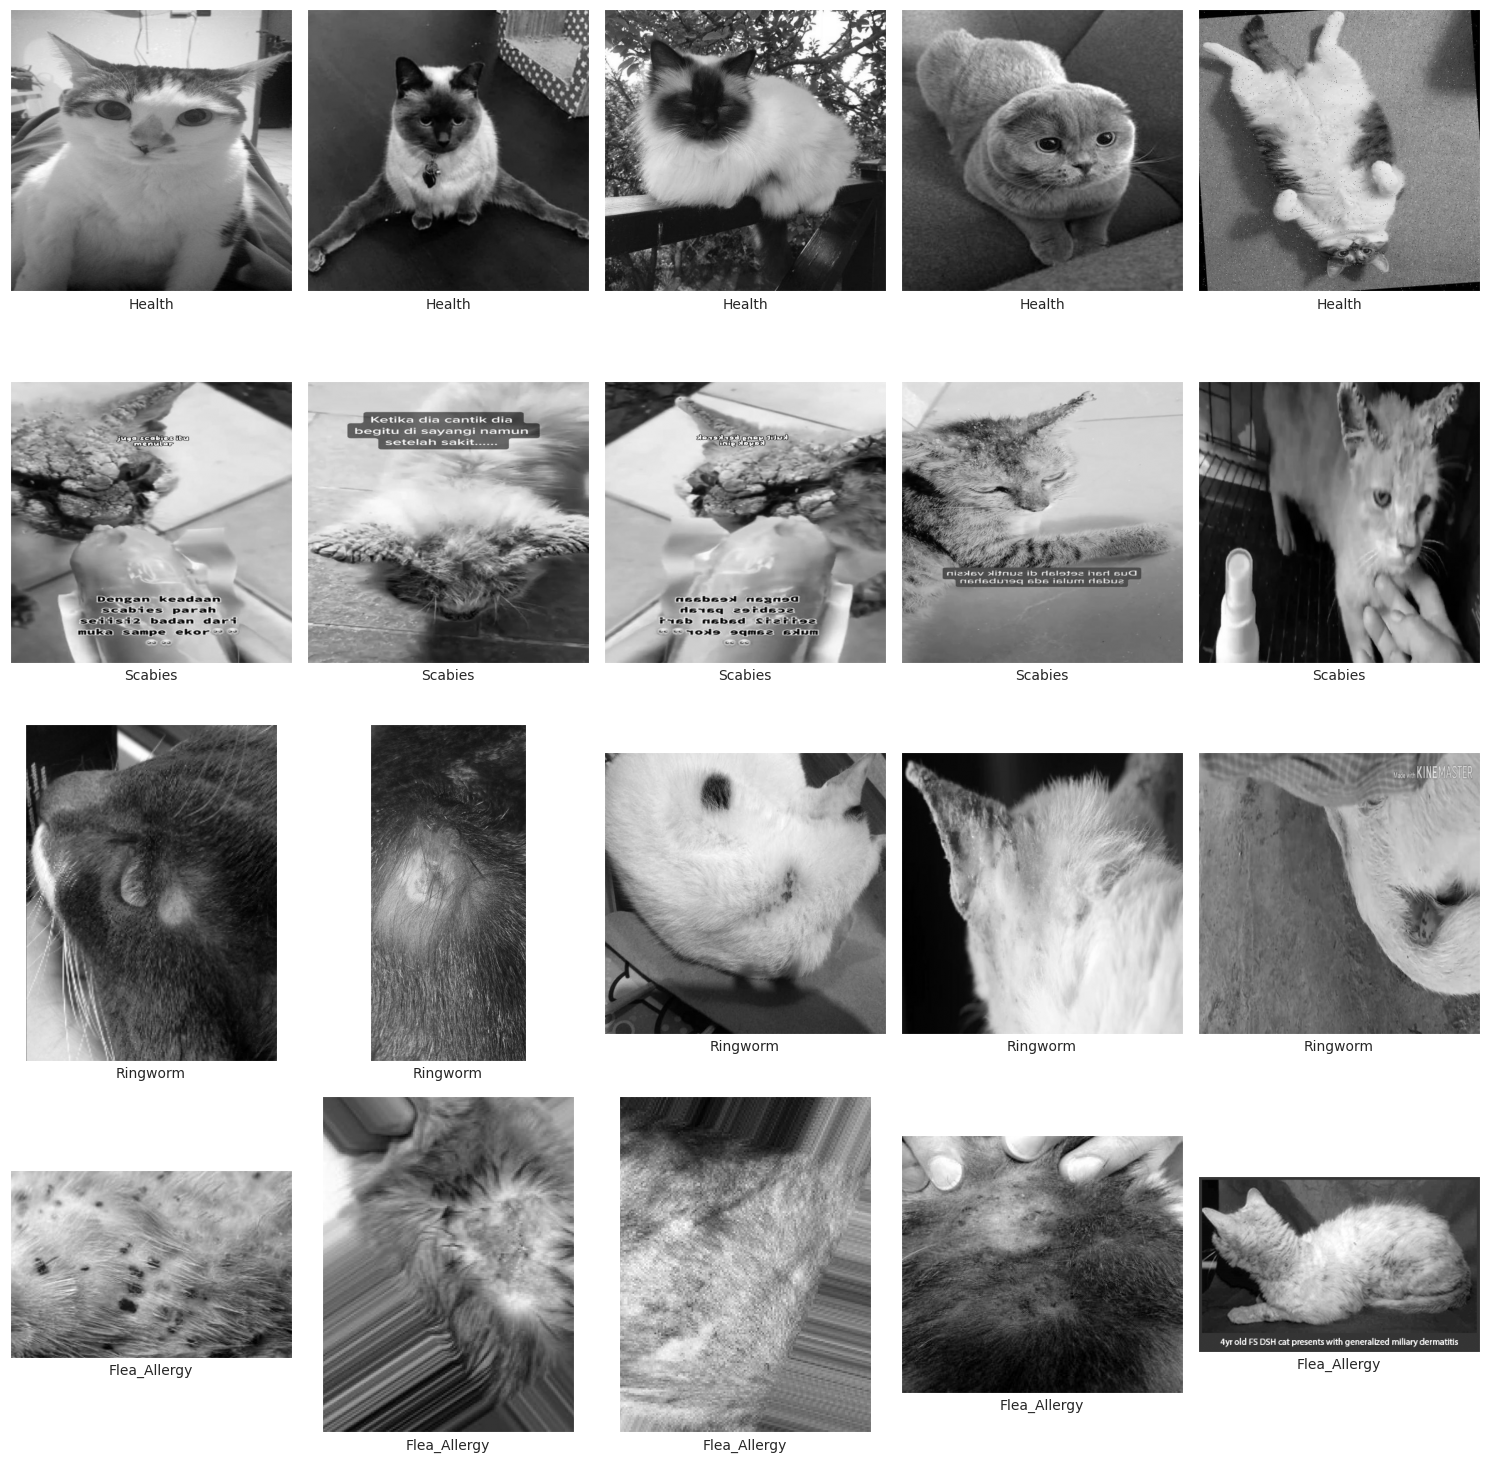

In [285]:
# Membuat kamus yang menyimpan nama gambar untuk setiap kelas
cat_image = {}

# Path ke direktori data
path = "CAT SKIN DISEASE/"

# Isi lung_image dengan daftar gambar dari masing-masing kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        image_files = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        cat_image[class_name] = image_files

# Pastikan lung_image terisi
if not cat_image:
    raise ValueError("Tidak ada data ditemukan di folder.")

# Menampilkan secara acak 5 gambar untuk setiap kelas
fig, axs = plt.subplots(len(cat_image.keys()), 5, figsize=(15, 15))

for i, (class_name, image_list) in enumerate(cat_image.items()):
    images = np.random.choice(image_list, 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi ke grayscale
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

## **Plot distribusi gambar di seluruh kelas**

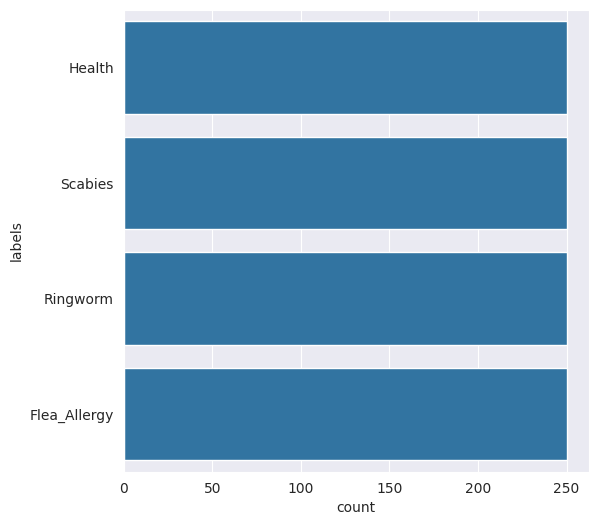

In [286]:
# Define source path
lung_path = "CAT SKIN DISEASE/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [287]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

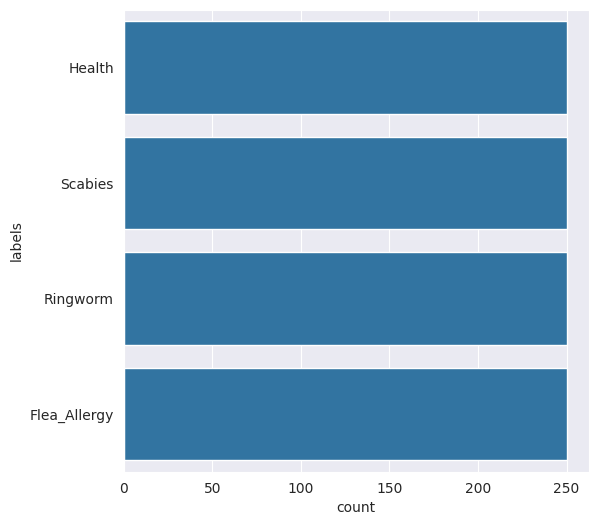

In [288]:
# Define source path
cat_path = "CAT SKIN DISEASE/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(cat_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting : Training and Testing**

In [289]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'CAT SKIN DISEASE/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Flea_Allergy,250
Health,250
Ringworm,250
Scabies,250


In [290]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Pertama, bagi data menjadi train dan sementara (temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=300)

# Kemudian, bagi temp menjadi test dan validation (misalnya 50% masing-masing dari temp)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=300)

In [291]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_valid = pd.DataFrame({'path': X_valid, 'labels': y_valid, 'set': 'validation'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [292]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))
print('valid size', len(df_valid))

train size 800
test size 100
valid size 100


In [293]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_valid], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set         labels      
test        Flea_Allergy     27
            Health           24
            Ringworm         24
            Scabies          25
train       Flea_Allergy    193
            Health          205
            Ringworm        204
            Scabies         198
validation  Flea_Allergy     30
            Health           21
            Ringworm         22
            Scabies          27
dtype: int64 


                                                  path        labels    set
215  CAT SKIN DISEASE/Scabies/frame10_83_jpg.rf.a07...       Scabies  train
357  CAT SKIN DISEASE/Scabies/frame3_149_jpg.rf.b27...       Scabies  train
232         CAT SKIN DISEASE/Flea_Allergy/image_25.jpg  Flea_Allergy  train
381  CAT SKIN DISEASE/Ringworm/HOT-SPOT-IN-DOG-HOW-...      Ringworm  train
827  CAT SKIN DISEASE/Health/1181-xl6lWeHCXxo_jpg.r...        Health   test


In [294]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "CAT SKIN DISEASE/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [295]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In TensorFlow you can do this through the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to do:
- Configure the random transformation and normalization operations to be performed on the image data during training
- Instantiate generator of augmented image sets (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. This generator can then be used with `tf.keras` model methods which accept generator data as input, `fit`, `evaluate` and `predict`

Prepare the training and validation data, to begin with using `.flow_from_directory()` which generates image datasets and their labels directly in their respective folders by setting the `WIDTH` and `HEIGHT` size, predefined `BATCH SIZE` size and mode its class. Here we use `"binary"` class mode because the number of classes used is 2.

In [296]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"
VALID_DIR = "Dataset-Final/validation"

train_health = os.path.join(TRAIN_DIR + '/Health')
train_flea = os.path.join(TRAIN_DIR + '/Flea_Allergy')
train_ringworm = os.path.join(TRAIN_DIR + '/Ringworm')
train_scabies = os.path.join(TRAIN_DIR + '/Scabies')

test_health = os.path.join(TEST_DIR + '/Health')
test_flea = os.path.join(TEST_DIR + '/Flea_Allergy')
test_ringworm = os.path.join(TEST_DIR + '/Ringworm')
test_scabies = os.path.join(TEST_DIR + '/Scabies')

valid_health = os.path.join(VALID_DIR + '/Health')
valid_flea = os.path.join(VALID_DIR + '/Flea_Allergy')
valid_ringworm = os.path.join(VALID_DIR + '/Ringworm')
valid_scabies = os.path.join(VALID_DIR + '/Scabies')

print("Total number of health images in training set: ",len(os.listdir(train_health)))
print("Total number of flea allergy images in training set: ",len(os.listdir(train_flea)))
print("Total number of ringworm images in training set: ",len(os.listdir(train_ringworm)))
print("Total number of scabies images in training set: ",len(os.listdir(train_scabies)))

print("Total number of health images in testing set: ",len(os.listdir(test_health)))
print("Total number of flea allergy images in testing set: ",len(os.listdir(test_flea)))
print("Total number of ringworm images in training set: ",len(os.listdir(test_ringworm)))
print("Total number of scabies images in training set: ",len(os.listdir(test_scabies)))

print("Total number of health images in validation set: ",len(os.listdir(valid_health)))
print("Total number of flea allergy images in validation set: ",len(os.listdir(valid_flea)))
print("Total number of ringworm images in training set: ",len(os.listdir(valid_ringworm)))
print("Total number of scabies images in training set: ",len(os.listdir(valid_scabies)))

Total number of health images in training set:  205
Total number of flea allergy images in training set:  193
Total number of ringworm images in training set:  204
Total number of scabies images in training set:  198
Total number of health images in testing set:  24
Total number of flea allergy images in testing set:  27
Total number of ringworm images in training set:  24
Total number of scabies images in training set:  25
Total number of health images in validation set:  21
Total number of flea allergy images in validation set:  30
Total number of ringworm images in training set:  22
Total number of scabies images in training set:  27


In [297]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size harus sama dengan input MobileNetV2 (150x150 dalam kasus ini)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Data augmentation + validation split untuk train & val
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # subset untuk training
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # subset untuk validasi
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 642 images belonging to 4 classes.
Found 158 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


# **Model Transfer Learning using MobileNetV2:**

In [298]:
from tensorflow.keras.applications import MobileNetV2

# Load pretrained base model
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze weights

# Tambahkan custom CNN layers setelah base_model
x = base_model.output
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4 kelas output

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-298-8ef6589825ff>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,662,372 (10.16 MB)

 Trainable params: 404,196 (1.54 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

In [299]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True)
]

count_health = len(os.listdir(train_health))
count_flea = len(os.listdir(train_flea))
count_ringworm = len(os.listdir(train_ringworm))
count_scabies = len(os.listdir(train_scabies))

# Menghitung weight untuk setiap kelas
weight_0 = (1 / count_health) * (count_health + count_flea + count_ringworm + count_scabies) / 4.0
weight_1 = (1 / count_flea) * (count_health + count_flea + count_ringworm + count_scabies) / 4.0
weight_2 = (1 / count_ringworm) * (count_health + count_flea + count_ringworm + count_scabies) / 4.0
weight_3 = (1 / count_scabies) * (count_health + count_flea + count_ringworm + count_scabies) / 4.0

# Membuat dictionary untuk class_weight
class_weights = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3}

history_1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 846ms/step - accuracy: 0.2851 - loss: 1.8337 - val_accuracy: 0.3291 - val_loss: 1.3127
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.3715 - loss: 1.4698 - val_accuracy: 0.4241 - val_loss: 1.2293
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.4453 - loss: 1.3293 - val_accuracy: 0.4937 - val_loss: 1.1560
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.4590 - loss: 1.2816 - val_accuracy: 0.5380 - val_loss: 1.0817
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.4914 - loss: 1.1439 - val_accuracy: 0.5127 - val_loss: 1.0983
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.5520 - loss: 1.0400 - val_accuracy: 0.5886 - val_loss: 1.0290
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.5696 - loss: 1.0211 - val_accuracy: 0.6139 - val_loss: 1.0077
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.5962 - loss: 1.0147 - val_accuracy: 

In [300]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8262 - loss: 0.4822
Test Accuracy: 0.81


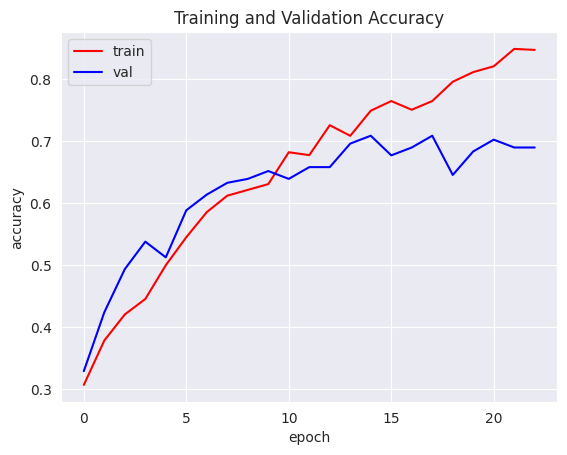

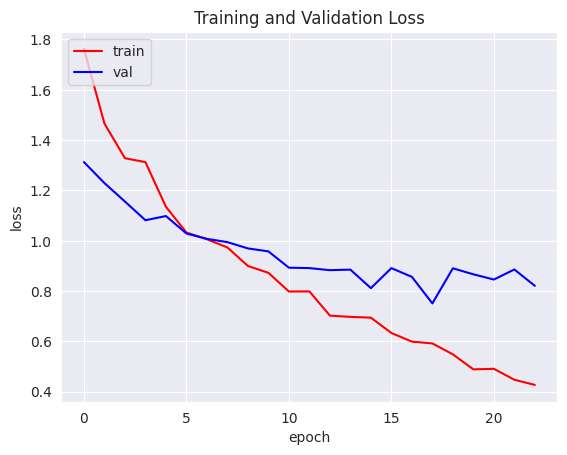

In [301]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()



              precision    recall  f1-score   support

      Health     0.9200    0.8519    0.8846        27
        Flea     0.7188    0.9583    0.8214        24
    Ringworm     0.7500    0.7500    0.7500        24
     Scabies     0.8947    0.6800    0.7727        25

    accuracy                         0.8100       100
   macro avg     0.8209    0.8100    0.8072       100
weighted avg     0.8246    0.8100    0.8092       100



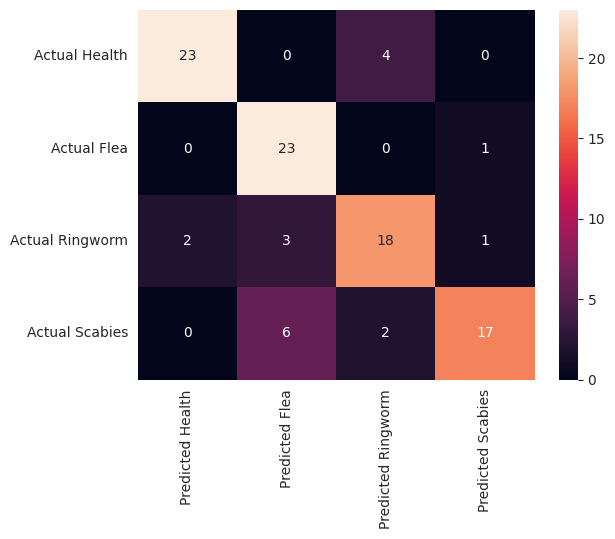

In [302]:
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2, 3]),index=["Actual Health", "Actual Flea", "Actual Ringworm", "Actual Scabies"],
columns=["Predicted Health", "Predicted Flea", "Predicted Ringworm", "Predicted Scabies"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Health','Flea', 'Ringworm', 'Scabies'], digits=4))

## **Konversi Model**

In [303]:
# Konversi ke Saved_model
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_9654')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137405695034000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137405695040528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606606352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137405695034768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137405695038224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606617488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606616336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606613840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606615184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137407606606736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13740760661096

In [ ]:
# Cek apakah folder saved_model dan isinya sudah disimpan
if os.path.exists('saved_model'):
    print("Model saved in 'saved_model' folder.")
    print("Contents of 'saved_model':", os.listdir('saved_model'))
else:
    print("Model not saved.")

In [304]:
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

# Simpan model.tflite
os.makedirs("tflite", exist_ok=True)
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
labels = ["Flea_Allergy", "Health", "Ringworm", "Scabies"]
with open("tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

In [ ]:
os.makedirs('tfjs_model', exist_ok=True)
model.save("tfjs_model/model.h5")

In [305]:
!pip install tensorflowjs

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

# Load model dari .h5
model = tf.keras.models.load_model('tfjs_model/model.h5')

# Save ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

## **Testing**

Saving 27_png.rf.247527ae8a3f024f38e3f112c24523f8.jpg to 27_png.rf.247527ae8a3f024f38e3f112c24523f8 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Gambar: 27_png.rf.247527ae8a3f024f38e3f112c24523f8 (1).jpg
Prediksi: Scabies
Probabilitas: [[0.02005535 0.05584896 0.00701845 0.91707724]]




Saran Perawatan:

Scabies atau kudis pada kucing disebabkan oleh infestasi tungau Sarcoptes atau Notoedres, dan sangat
menular. Gejalanya meliputi rasa gatal ekstrem, kulit menebal dan bersisik, luka akibat garukan, dan
bisa disertai infeksi sekunder. Perawatan dimulai dengan membawa kucing ke dokter hewan untuk
diagnosis pasti (kadang melalui scraping kulit). Dokter akan memberikan obat seperti ivermectin,
selamectin, atau milbemycin. Mandikan kucing dengan shampo khusus antiparasit dan rawat kulit yang
terinfeksi agar tidak terjadi luka terbuka. Isolasi kucing selama masa perawatan agar tidak
menularkan ke hewan atau manusia lain. Lingkungan juga harus dibersihkan secara intensif, dan
perawatan harus dilanjutkan sampai tungau benar-benar hilang.


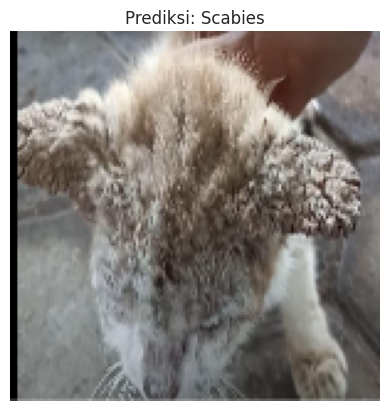

In [306]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
from IPython.display import display, Markdown

# Load model
model = load_model('model.h5')  # Ganti dengan nama model kamu

# Label kelas
class_labels = ['Flea_Allergy', 'Health', 'Ringworm', 'Scabies']

# Saran perawatan berdasarkan prediksi
treatment_suggestions = {
    'Health': "Kulit kucing tampak sehat dan bebas dari gejala penyakit kulit. Untuk menjaga kesehatan ini, pastikan kucing Anda tetap berada di lingkungan yang bersih dan bebas dari parasit seperti kutu dan tungau. Berikan makanan bernutrisi tinggi yang mengandung omega-3 dan omega-6 untuk menjaga kesehatan kulit dan bulu. Mandikan kucing secara rutin (sekitar 1-2 kali per bulan) dengan shampo khusus kucing yang lembut. Lakukan grooming untuk menghindari bulu kusut dan memeriksa adanya tanda-tanda penyakit secara dini. Jangan lupa untuk menjadwalkan pemeriksaan rutin ke dokter hewan minimal 1 kali setiap 6 bulan.",
    'Flea_Allergy': "Kucing menunjukkan gejala alergi terhadap gigitan kutu, yang biasanya berupa gatal parah, kerontokan rambut lokal, dan luka akibat garukan. Langkah pertama adalah segera memberikan pengobatan antiparasit seperti spot-on atau obat oral yang direkomendasikan oleh dokter hewan. Mandikan kucing dengan shampo anti-kutu khusus kucing, dan hindari penggunaan produk manusia karena bisa berbahaya. Bersihkan seluruh area tempat kucing sering berada—termasuk kasur, karpet, dan furnitur—karena kutu juga bisa bersarang di sana. Gunakan vacuum cleaner secara rutin dan pertimbangkan menyemprotkan obat pembasmi kutu di lingkungan sekitar. Bila kondisi tidak membaik dalam beberapa hari, segera konsultasikan ulang ke dokter hewan untuk penanganan lanjutan.",
    'Ringworm': "Ringworm atau dermatofitosis adalah infeksi jamur yang sangat menular, baik ke sesama kucing, hewan lain, maupun manusia. Tanda-tandanya termasuk kerontokan bulu berbentuk melingkar, kulit kemerahan, dan bersisik. Perawatan dimulai dengan mengisolasi kucing dari hewan peliharaan lainnya untuk mencegah penyebaran. Berikan salep anti-jamur seperti miconazole atau ketoconazole sesuai resep dokter. Mandikan kucing dengan shampo anti-jamur secara teratur. Semua barang yang pernah disentuh kucing harus dibersihkan dan didesinfeksi, termasuk tempat tidur dan mainan. Pengobatan oral mungkin dibutuhkan dalam kasus berat. Karena infeksi jamur bisa berlangsung lama, tetap disiplin dalam perawatan dan terus kontrol ke dokter hingga kucing benar-benar sembuh.",
    'Scabies': "Scabies atau kudis pada kucing disebabkan oleh infestasi tungau Sarcoptes atau Notoedres, dan sangat menular. Gejalanya meliputi rasa gatal ekstrem, kulit menebal dan bersisik, luka akibat garukan, dan bisa disertai infeksi sekunder. Perawatan dimulai dengan membawa kucing ke dokter hewan untuk diagnosis pasti (kadang melalui scraping kulit). Dokter akan memberikan obat seperti ivermectin, selamectin, atau milbemycin. Mandikan kucing dengan shampo khusus antiparasit dan rawat kulit yang terinfeksi agar tidak terjadi luka terbuka. Isolasi kucing selama masa perawatan agar tidak menularkan ke hewan atau manusia lain. Lingkungan juga harus dibersihkan secara intensif, dan perawatan harus dilanjutkan sampai tungau benar-benar hilang."
}

# Upload gambar dari user
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load dan preprocess gambar
    img = image.load_img(file_name, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    # Output
    print(f"\nGambar: {file_name}")
    print(f"Prediksi: {predicted_label}")
    print(f"Probabilitas: {prediction}")
    # Tambahkan enter dan buat heading tebal
    display(Markdown("\n\nSaran Perawatan:"))

    # Wrap dan tampilkan isi saran
    wrapped_text = textwrap.fill(treatment_suggestions[predicted_label], width=100)
    print(wrapped_text)


    # Tampilkan gambar
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_label}")
    plt.axis('off')
    plt.show()